Представьте, что вы работаете в государственной компании, предоставляющей анализ экономической ситуации в мире по заказу государства.

Перед вами стоит задача проанализировать ВВП африканской страны Гана. Для этого вам предоставили показатели ВВП Ганы за 62 года. Вам предстоит исследовать временной ряд, изучить его свойства, построить модели и сделать выводы по результатам.

In [50]:
from warnings import filterwarnings
filterwarnings("ignore")

In [51]:
import pandas as pd

data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns={"GDP (current US$)":"gdp"}, inplace=True)
data.tail()

,gdp
year,
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10
2020-01-01,7.004320e+10
2021-01-01,7.759428e+10


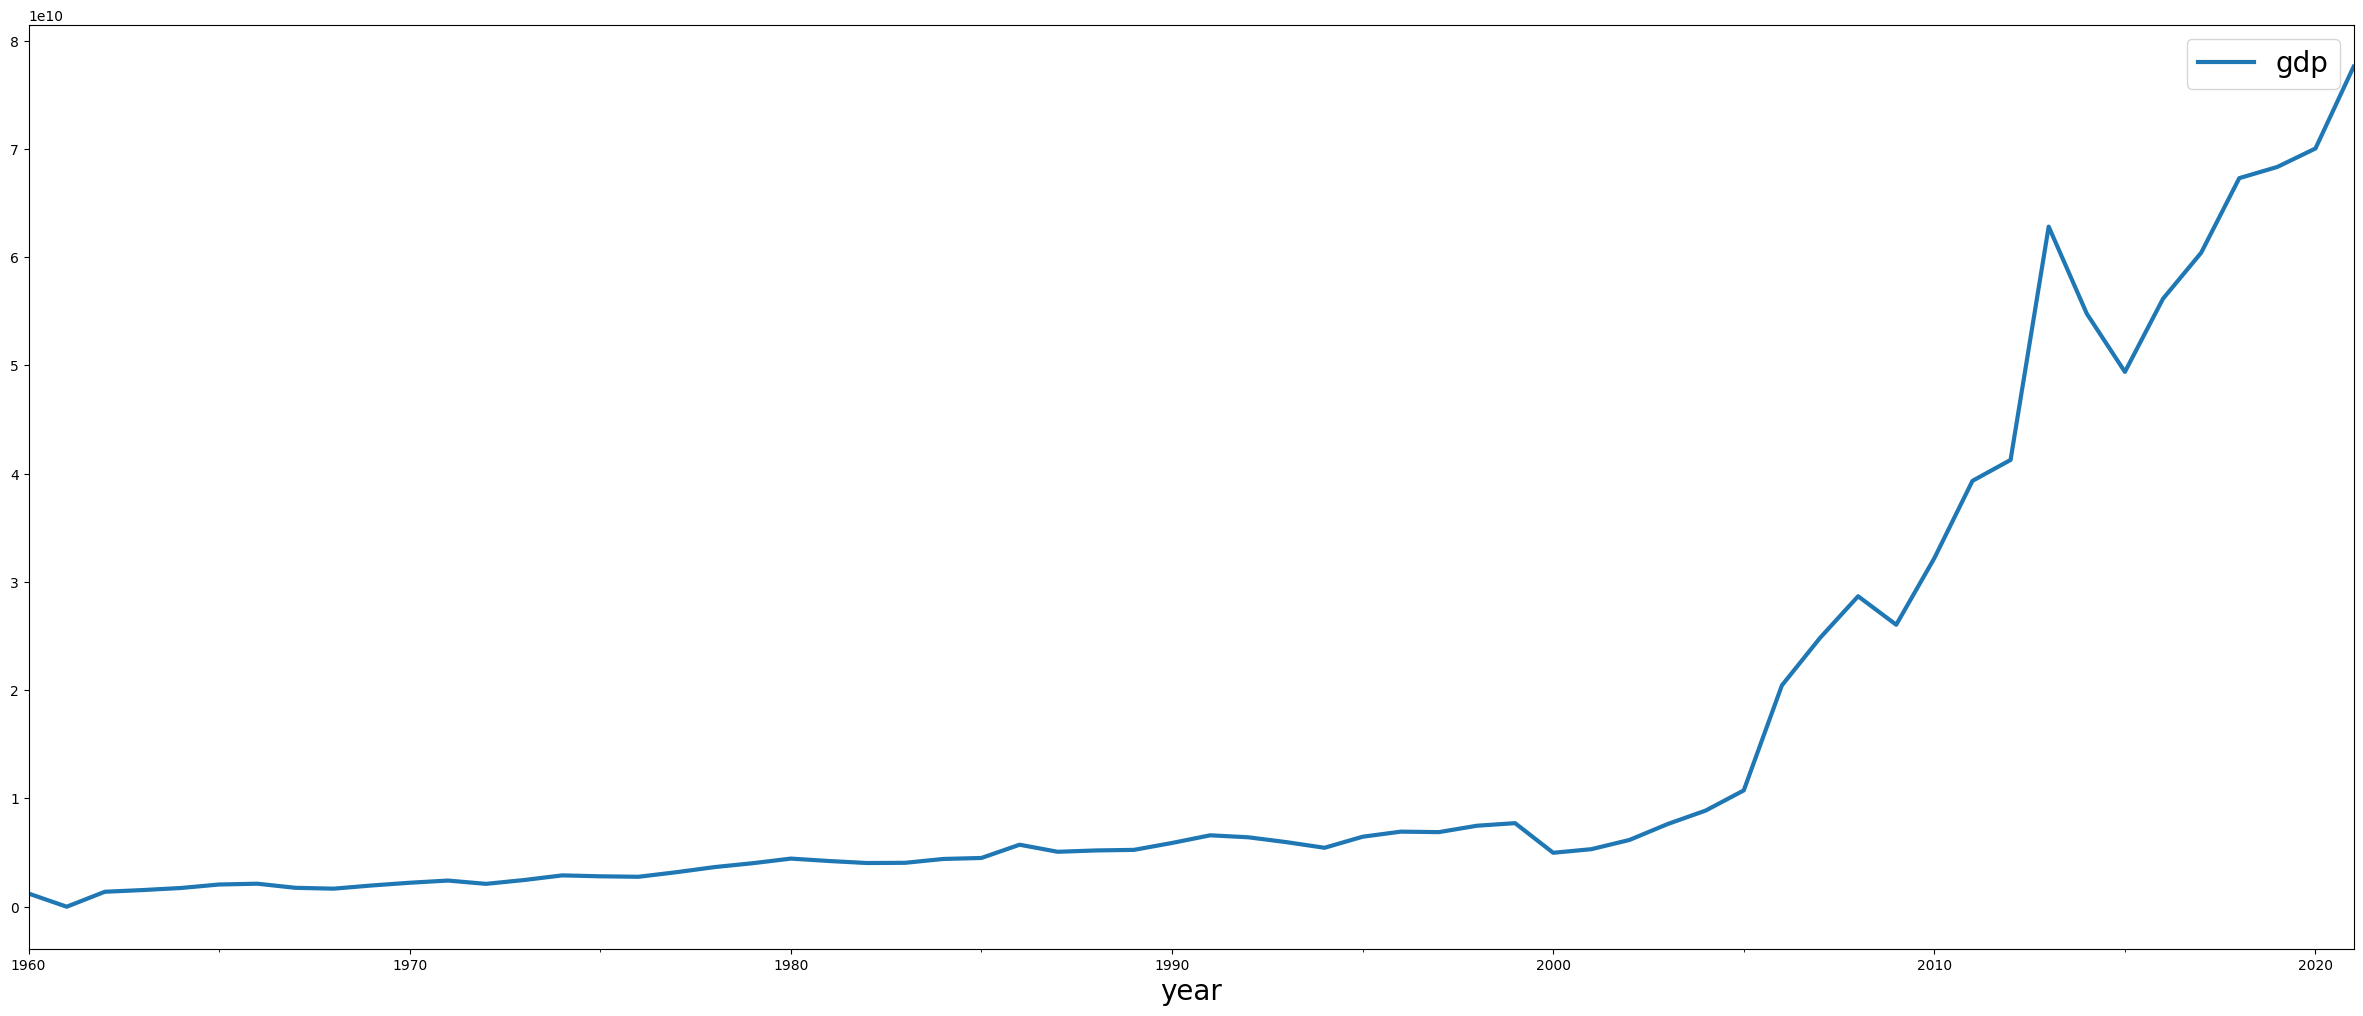

In [52]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

## Разбиение на тренировочную и тестовую выборку.

In [53]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

## Визуализация тренда, сезонности, шума

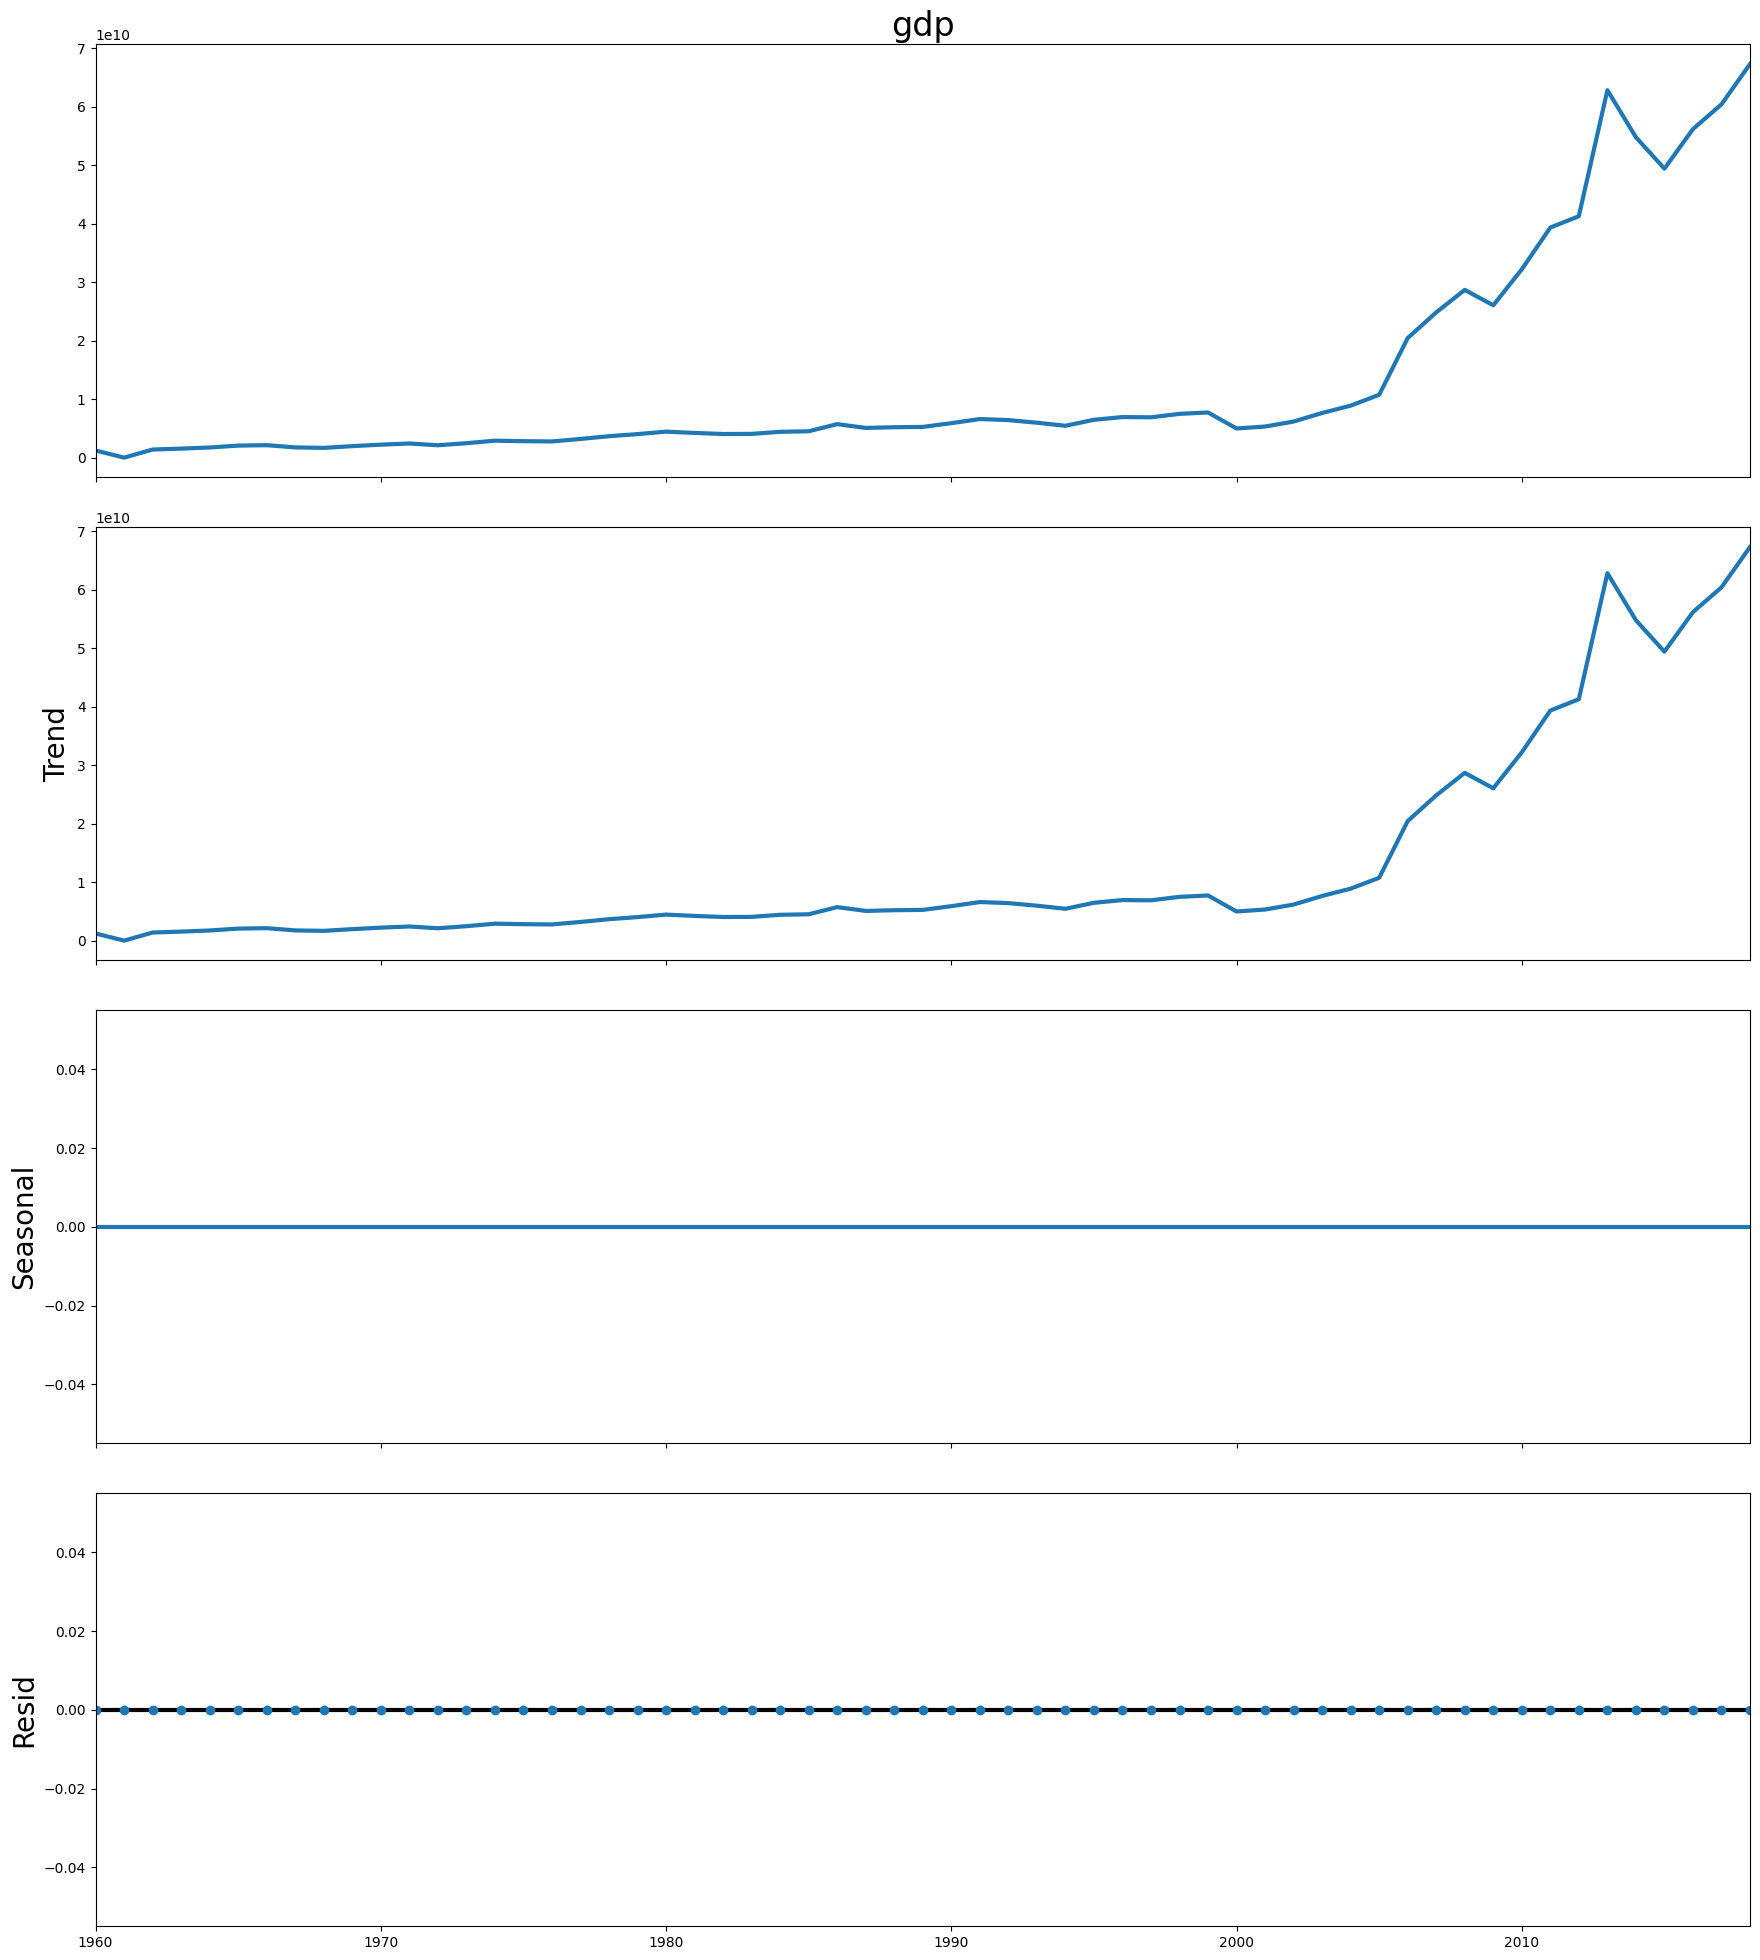

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.gdp)
result.plot()
plt.show()

1. Предварительно сезонности нет, тренд был с 1960 до 2005, потом появился новый тренд.

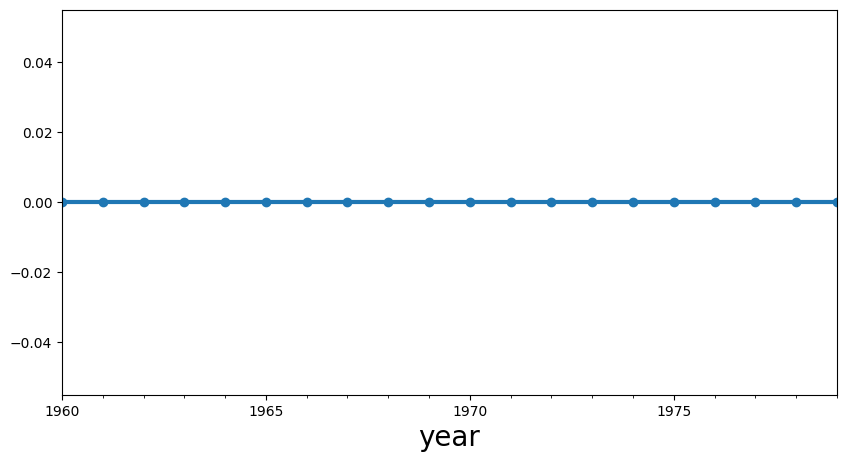

In [55]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

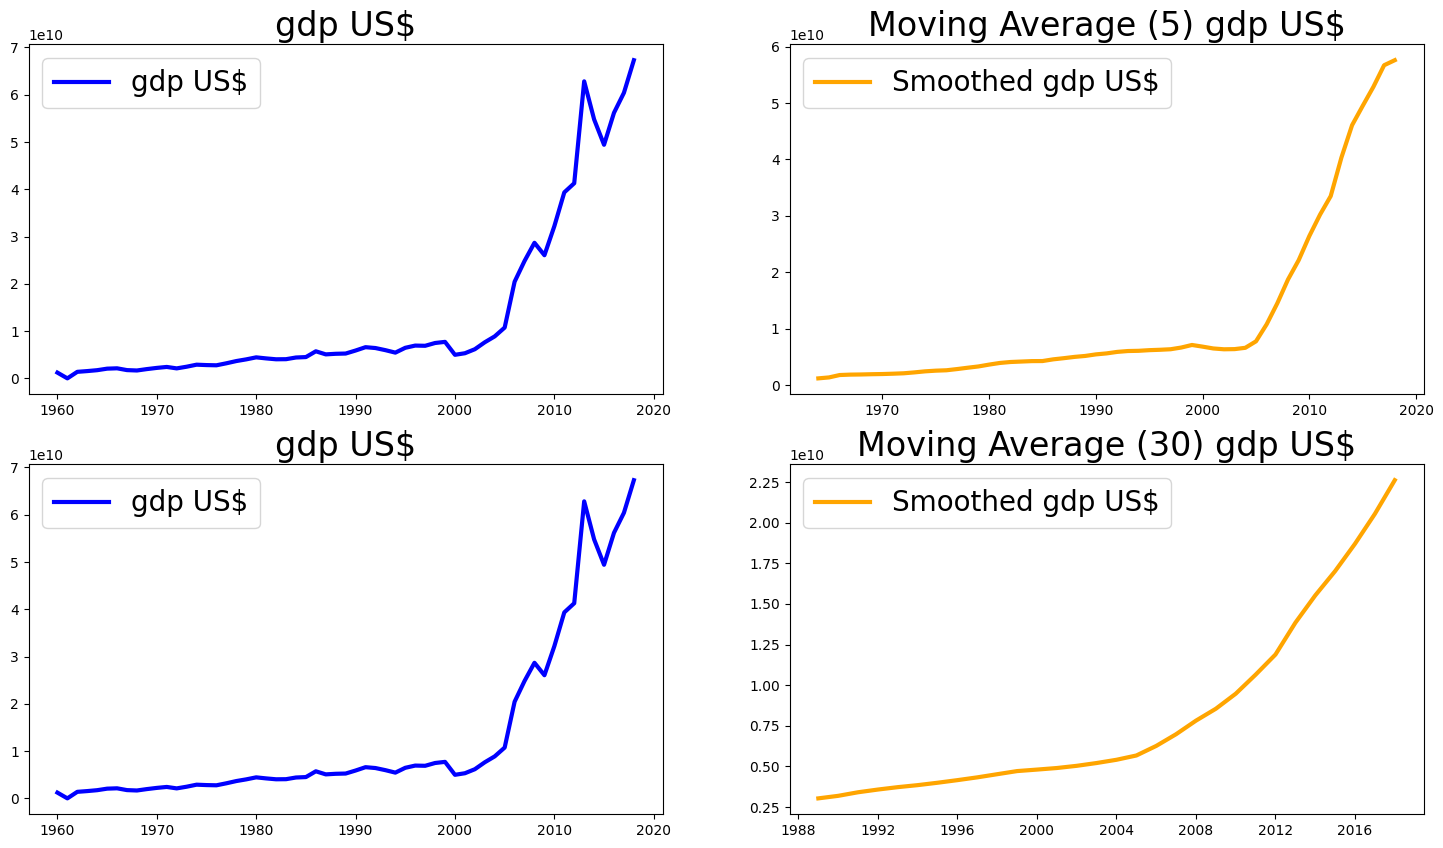

In [56]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.gdp, color="blue", label="gdp US$")
ax[0, 0].set_title("gdp US$", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.gdp.rolling(window=5).mean(),
    color="orange",
    label="Smoothed gdp US$",
)

ax[0, 1].set_title("Moving Average (5) gdp US$", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.gdp, color="blue", label="gdp US$")
ax[1, 0].set_title("gdp US$", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.gdp.rolling(window=30).mean(),
    color="orange",
    label="Smoothed gdp US$",
)

ax[1, 1].set_title("Moving Average (30) gdp US$", size=24)
ax[1, 1].legend()

plt.show()

2. Графики справа напоминают экспоненту, то есть скользящее среднее (МА) является экспонентой.

## Тест Дики-Фуллера на проверку станционарности ряда

In [57]:
from statsmodels.tsa.stattools import adfuller

def check_stationar(data):
    result = adfuller(data)
    print("adf: ", result[0])
    print("p-value: ", result[1])
    print("Critical values: ", result[4])
    if result[0] > result[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")

check_stationar(train_df["gdp"])

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


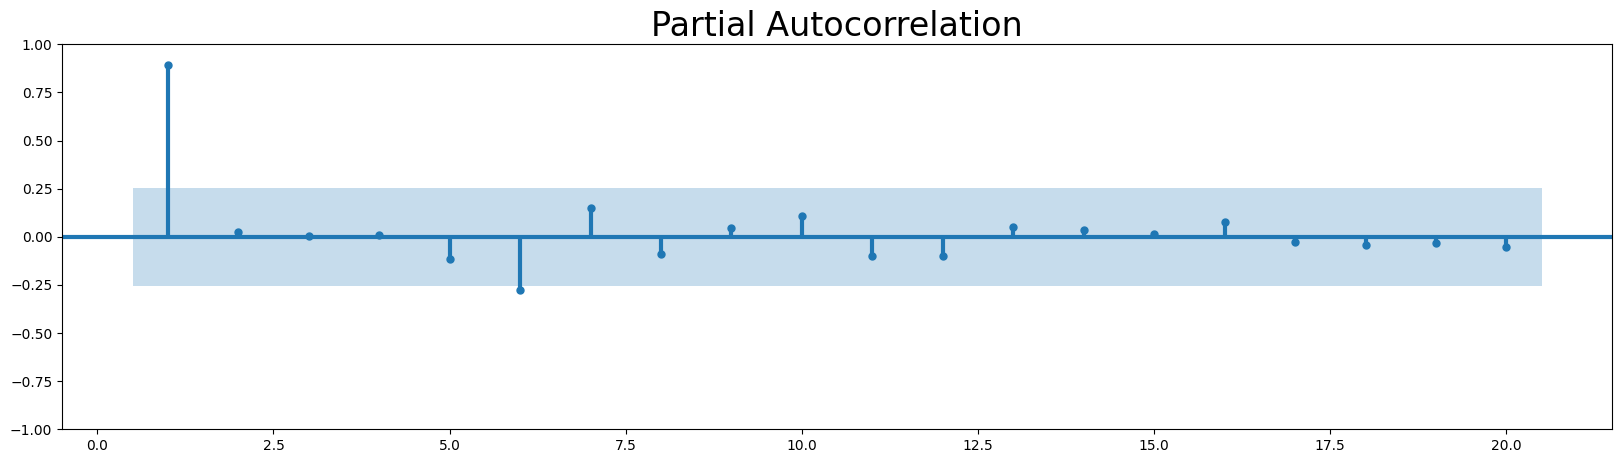

In [58]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.gdp, lags=20, method="ywm", zero=False)
plt.show()

### Функция для построения ACF/PACF

In [59]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=25)
    sgt.plot_pacf(series, ax=axes[1], lags=25, method="ywm")

(-1.6702483038320777,
 0.446502932971389,
 7,
 50,
 {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616},
 2147.2038799920597)

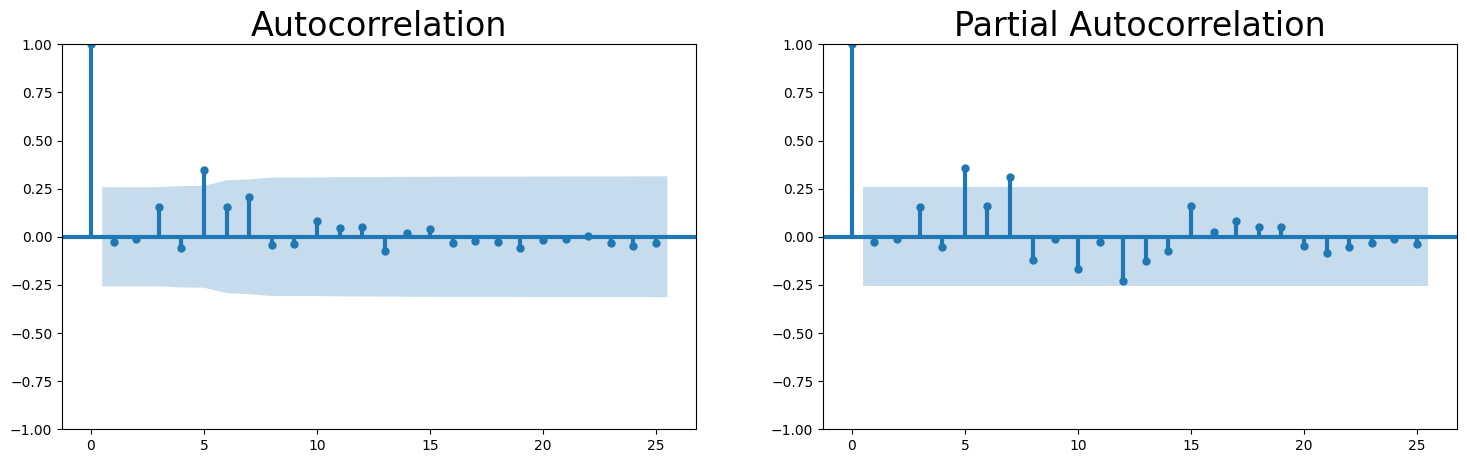

In [60]:
plot_acf_pacf(train_df["gdp"].diff().dropna())
adfuller(train_df["gdp"].diff().dropna())

In [61]:
# Дифференцирование ряда
diff_series = train_df["gdp"].diff().dropna()

check_stationar(diff_series)

adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [62]:
diff_2 = diff_series.diff().dropna()

check_stationar(diff_2)

adf:  -2.6408690561284898
p-value:  0.08484116917837664
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


## В целом adf < 10%, поэтому можно сказать что ряд стационарен (но на грани)

2. Определение параметров p и q по ACF и PACF.
    После приведения ряда к стационарному виду, можно построить коррелограммы ACF (автокорреляционная функция) и PACF (частичная автокорреляционная функция).

* ACF показывает значения корреляции между текущим значением временного ряда и его значениями с прошлых шагов (lags).
* PACF показывает чистую корреляцию между текущим значением и его значением на предыдущем шаге, исключая влияние промежуточных лагов.

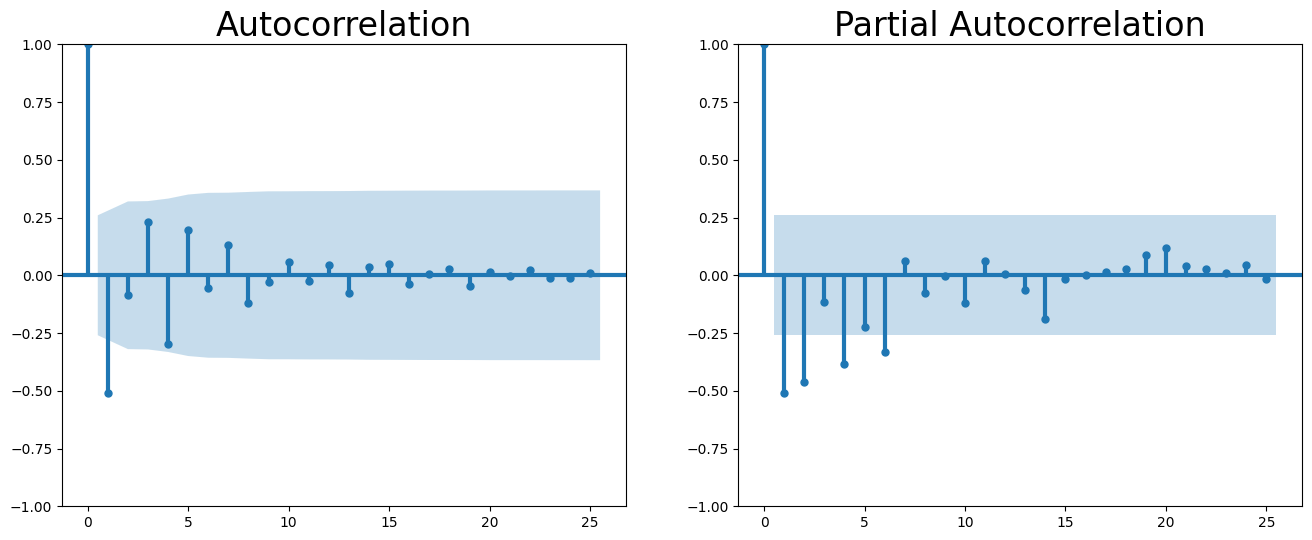

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Построение ACF и PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(diff_2, lags=25, ax=ax[0])
plot_pacf(diff_2, lags=25, ax=ax[1])

plt.show()

* Если PACF резко обрывается после лага p, это говорит о наличии AR(p).
* Если ACF резко обрывается после лага q, это говорит о наличии MA(q).

3. Построение и оценка модели ARIMA
    После выбора параметров p, d, q можно построить модель ARIMA.

In [64]:
from statsmodels.tsa.arima.model import ARIMA

# Построение модели ARIMA
model = ARIMA(train_df, order=(7, 3, 7))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   59
Model:                 ARIMA(7, 3, 7)   Log Likelihood               -1299.533
Date:                Sun, 01 Sep 2024   AIC                           2629.065
Time:                        16:24:43   BIC                           2659.446
Sample:                    01-01-1960   HQIC                          2640.844
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0433      1.196     -0.873      0.383      -3.387       1.300
ar.L2         -1.0914      1.636     -0.667      0.505      -4.298       2.115
ar.L3         -1.0252      2.084     -0.492      0.6

4. Поиск параметров и лучшей модели через pmdarima.

In [65]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=5,
    max_q=5,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[5]             : AIC=2456.784, Time=0.06 sec
 ARIMA(0,2,0)(0,1,0)[5]             : AIC=2486.053, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[5]             : AIC=2471.473, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[5]             : AIC=2455.078, Time=0.05 sec
 ARIMA(0,2,1)(0,1,0)[5]             : AIC=2460.104, Time=0.03 sec
 ARIMA(0,2,1)(1,1,1)[5]             : AIC=2456.848, Time=0.08 sec
 ARIMA(0,2,1)(0,1,2)[5]             : AIC=2456.621, Time=0.08 sec
 ARIMA(0,2,1)(1,1,0)[5]             : AIC=2455.806, Time=0.03 sec
 ARIMA(0,2,1)(1,1,2)[5]             : AIC=2458.536, Time=0.18 sec
 ARIMA(0,2,0)(0,1,1)[5]             : AIC=2486.232, Time=0.03 sec
 ARIMA(0,2,2)(0,1,1)[5]             : AIC=2459.110, Time=0.05 sec
 ARIMA(1,2,0)(0,1,1)[5]             : AIC=2472.576, Time=0.03 sec
 ARIMA(1,2,2)(0,1,1)[5]             : AIC=2459.020, Time=0.11 sec
 ARIMA(0,2,1)(0,1,1)[5] intercept   : AIC=2467.037, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,1,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   59
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 5)   Log Likelihood               -1224.539
Date:                           Sun, 01 Sep 2024   AIC                           2455.078
Time:                                   16:24:44   BIC                           2460.931
Sample:                               01-01-1960   HQIC                          2457.322
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9388      0.065    -14.475      0.000      -1.066      -0.812
ma.S.L5       -0.5531      0.201     -2.757      0.006      -0.946      -0.160
sigma2      2.533e+19   4.06e-21   6.24e+39      0.000    2.53e+19    2.53e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):               250.43
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):             197.51   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.79e+54. Standard errors may be unstable.
"""

* лучшая модель - SARIMAX при таких параметрах (4,3,3)(0,1,0)[5]
Поэтому обучим модель SARIMAX.

In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

# Построение модели ARIMA
model = SARIMAX(train_df, order=(0, 2, 1), seasonal_order=(0, 1, 0, 5))
best_model_fit = model.fit()

print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                gdp   No. Observations:                   59
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 5)   Log Likelihood               -1228.052
Date:                            Sun, 01 Sep 2024   AIC                           2460.104
Time:                                    16:24:44   BIC                           2464.006
Sample:                                01-01-1960   HQIC                          2461.600
                                     - 01-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9798      0.105     -9.353      0.000      -1.185      -0.774
sigma2      2.533e+19    1.3e-21   

5. Прогнозирование
После выбора наилучшей модели можно выполнить прогнозирование на будущее.

In [67]:
forecast = best_model_fit.forecast(steps=3) # Прогноз на 3 шага вперёд
print(forecast)

2019-01-01    5.927363e+10
2020-01-01    5.391190e+10
2021-01-01    6.068505e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64


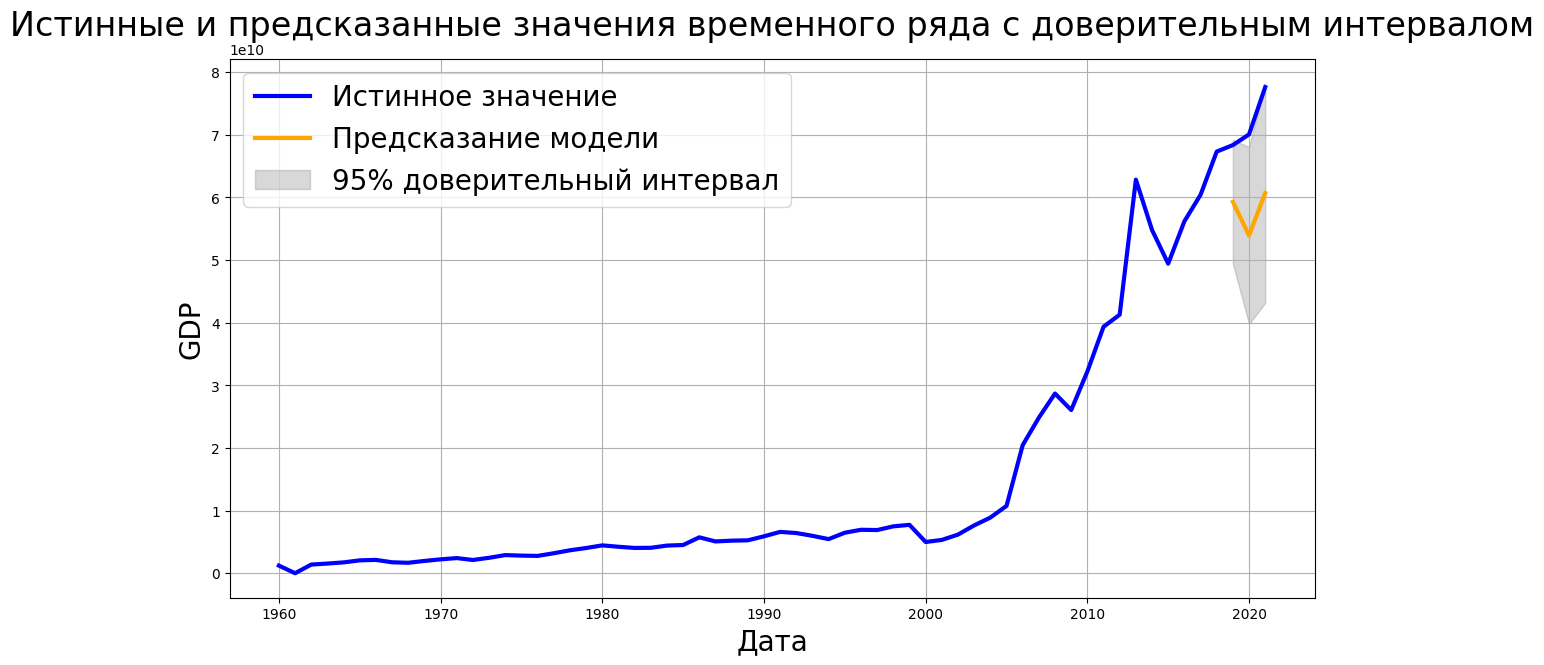

In [68]:
import pandas as pd
import matplotlib.pyplot as plt

# Создадим DataFrame для предсказаний
pred_df = pd.DataFrame(index=data.index)

# Добавляем предсказания модели
pred_df["model_preds"] = best_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

# Добавляем истинные значения GDP
pred_df["gdp"] = data["gdp"]

# Получаем прогноз и доверительные интервалы
forecast = best_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Уровень доверия 95%

# Записываем нижние и верхние границы доверительного интервала в DataFrame
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

# Построение графиков
plt.figure(figsize=(14, 7))

# Истинные значения
plt.plot(pred_df["gdp"], label="Истинное значение", color="blue")

# Предсказанные значения
plt.plot(pred_df["model_preds"], label="Предсказание модели", color="orange")

# Доверительный интервал
plt.fill_between(
    pred_df.index,
    pred_df["model_preds_lower"],
    pred_df["model_preds_upper"],
    color="gray",
    alpha=0.3,
    label="95% доверительный интервал"
)

# Оформление
plt.title("Истинные и предсказанные значения временного ряда с доверительным интервалом")
plt.xlabel("Дата")
plt.ylabel("GDP")
plt.legend()
plt.grid(True)
plt.show()

### Выводы: видно, что предсказания слегка отличаются от истинного значения, однако настоящие значения оказались в доверительном интервале.

Проблемы могут быть в параметрах модели, ведь pmdarima иногда ошибается.

---

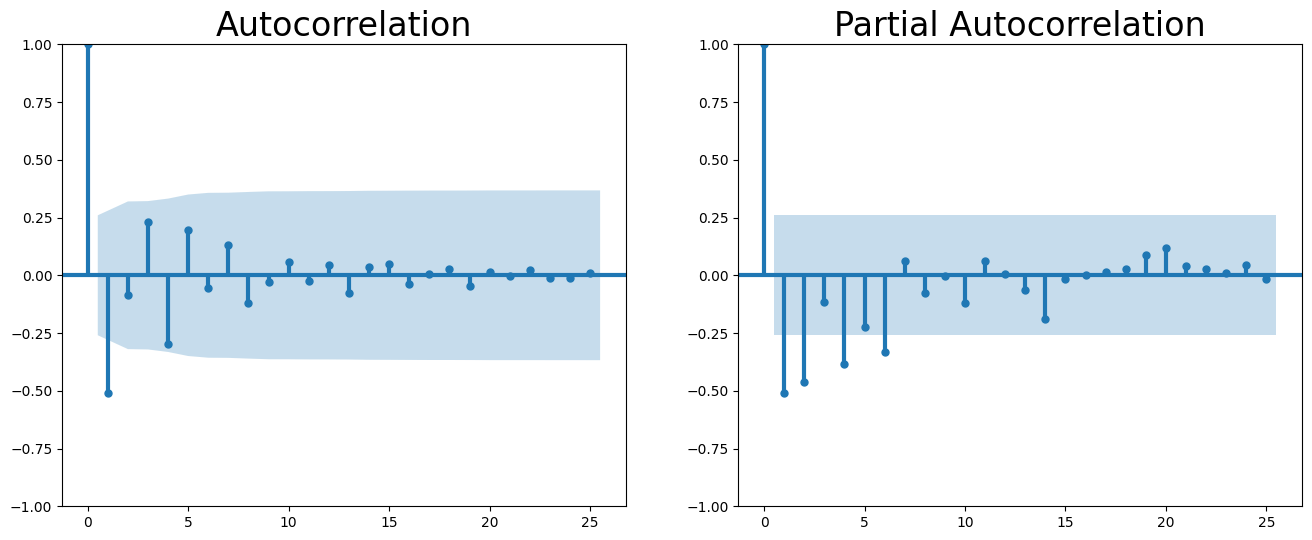

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Построение ACF и PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_acf(diff_2, lags=25, ax=ax[0])
plot_pacf(diff_2, lags=25, ax=ax[1])

plt.show()

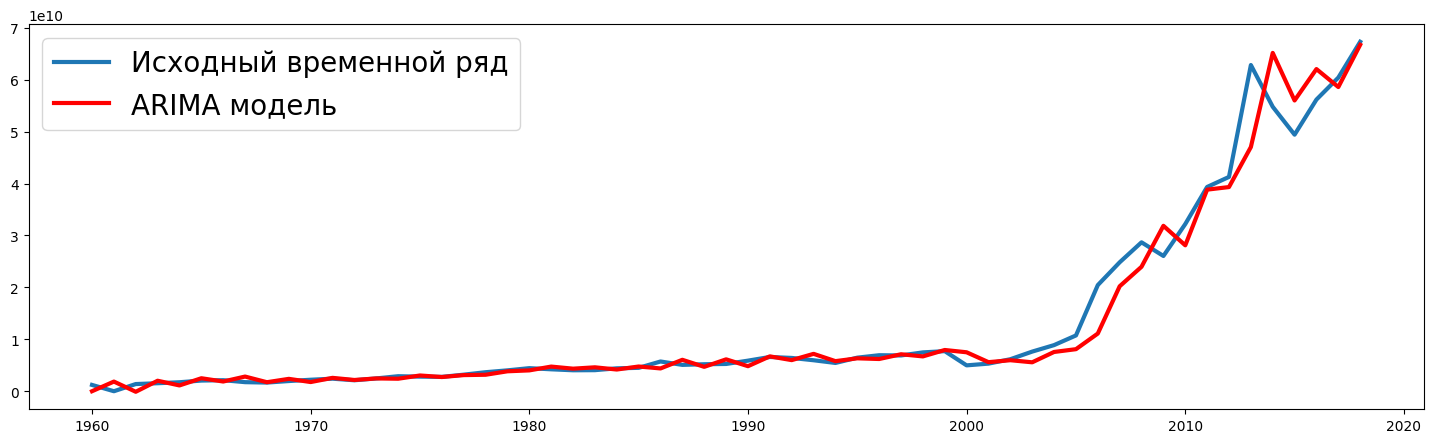

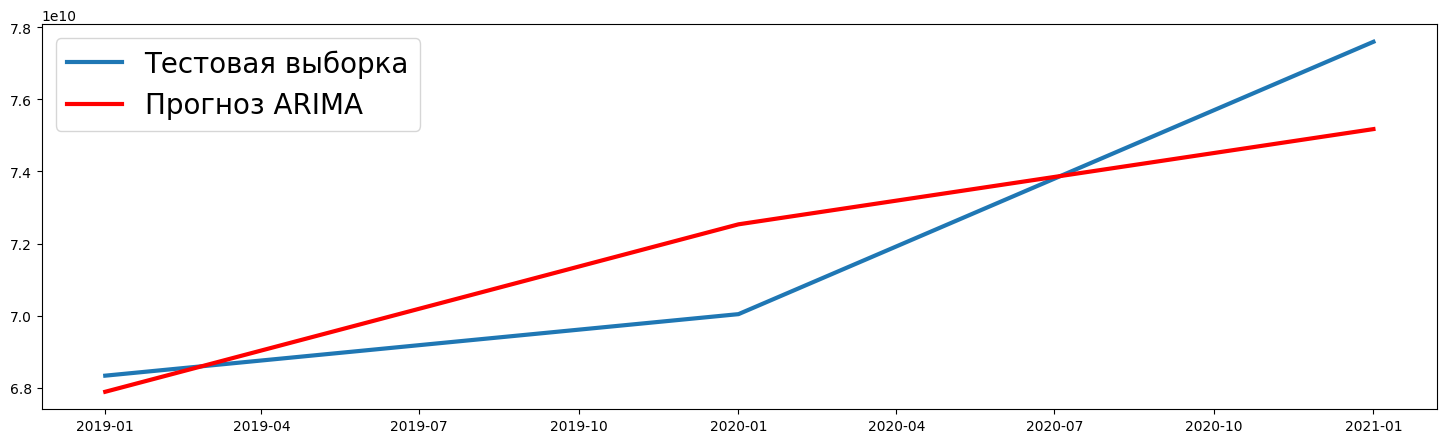

In [70]:
from pmdarima import auto_arima
# Найдем оптимальные параметры с помощью pmdarima
auto_model = auto_arima(train_df["gdp"], seasonal=False, suppress_warnings=True)
p, d, q = auto_model.order

# Построим модель ARIMA с найденными параметрами
arima_model = ARIMA(train_df["gdp"], order=(p, d, q))
arima_fit = arima_model.fit()

# Визуализация и сравнение с исходным временным рядом
plt.plot(train_df["gdp"], label="Исходный временной ряд")
plt.plot(arima_fit.fittedvalues, color='red', label="ARIMA модель")
plt.legend()
plt.show()

# Прогноз для тестовой выборки
forecast = arima_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')

# Оценка качества прогноза
plt.plot(test_df["gdp"], label="Тестовая выборка")
plt.plot(forecast, color='red', label="Прогноз ARIMA")
plt.legend()
plt.show()

In [71]:
p, d, q = auto_model.order
print(f"Подобранные параметры: p={p}, d={d}, q={q}")

Подобранные параметры: p=1, d=2, q=3


In [72]:
from statsmodels.tsa.arima.model import ARIMA

# Построение модели ARIMA
model = ARIMA(diff_2, order=(6, 3, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   57
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1286.575
Date:                Sun, 01 Sep 2024   AIC                           2589.151
Time:                        16:24:48   BIC                           2605.063
Sample:                    01-01-1962   HQIC                          2595.287
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8742      0.202     -9.256      0.000      -2.271      -1.477
ar.L2         -2.5123      0.312     -8.050      0.000      -3.124      -1.901
ar.L3         -2.4533      0.412     -5.957      0.0

In [73]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=2,
    start_q=1,
    max_p=5,
    max_q=5,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)
smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[5]             : AIC=2456.784, Time=0.10 sec
 ARIMA(0,2,0)(0,1,0)[5]             : AIC=2486.053, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[5]             : AIC=2471.473, Time=0.04 sec
 ARIMA(0,2,1)(0,1,1)[5]             : AIC=2455.078, Time=0.04 sec
 ARIMA(0,2,1)(0,1,0)[5]             : AIC=2460.104, Time=0.03 sec
 ARIMA(0,2,1)(1,1,1)[5]             : AIC=2456.848, Time=0.08 sec
 ARIMA(0,2,1)(0,1,2)[5]             : AIC=2456.621, Time=0.08 sec
 ARIMA(0,2,1)(1,1,0)[5]             : AIC=2455.806, Time=0.04 sec
 ARIMA(0,2,1)(1,1,2)[5]             : AIC=2458.536, Time=0.16 sec
 ARIMA(0,2,0)(0,1,1)[5]             : AIC=2486.232, Time=0.03 sec
 ARIMA(0,2,2)(0,1,1)[5]             : AIC=2459.110, Time=0.05 sec
 ARIMA(1,2,0)(0,1,1)[5]             : AIC=2472.576, Time=0.03 sec
 ARIMA(1,2,2)(0,1,1)[5]             : AIC=2459.020, Time=0.11 sec
 ARIMA(0,2,1)(0,1,1)[5] intercept   : AIC=2467.037, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,1,1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   59
Model:             SARIMAX(0, 2, 1)x(0, 1, 1, 5)   Log Likelihood               -1224.539
Date:                           Sun, 01 Sep 2024   AIC                           2455.078
Time:                                   16:24:49   BIC                           2460.931
Sample:                               01-01-1960   HQIC                          2457.322
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9388      0.065    -14.475      0.000      -1.066      -0.812
ma.S.L5       -0.5531      0.201     -2.757      0.006      -0.946      -0.160
sigma2      2.533e+19   4.06e-21   6.24e+39      0.000    2.53e+19    2.53e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):               250.43
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):             197.51   Skew:                             1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.79e+54. Standard errors may be unstable.
"""

### В обучении модели ARIMA мы используем изначальные данные, а дифферинцированные данные используем для нахождения p и в других случаях.

In [74]:
# Построение модели ARIMA
model = SARIMAX(train_df.gdp, order=(2, 2, 1), seasonal_order=(0, 1, 2, 5))
best_model_fit = model.fit()

print(best_model_fit.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                    gdp   No. Observations:                   59
Model:             SARIMAX(2, 2, 1)x(0, 1, [1, 2], 5)   Log Likelihood               -1219.510
Date:                                Sun, 01 Sep 2024   AIC                           2451.021
Time:                                        16:24:49   BIC                           2462.728
Sample:                                    01-01-1960   HQIC                          2455.509
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2493      0.126     -1.983      0.047      -0.496      -0.003
ar.

In [75]:
forecast = best_model_fit.forecast(steps=3) # Прогноз на 3 шага вперёд
print(forecast)

2019-01-01    6.375689e+10
2020-01-01    6.311265e+10
2021-01-01    6.797749e+10
Freq: AS-JAN, Name: predicted_mean, dtype: float64


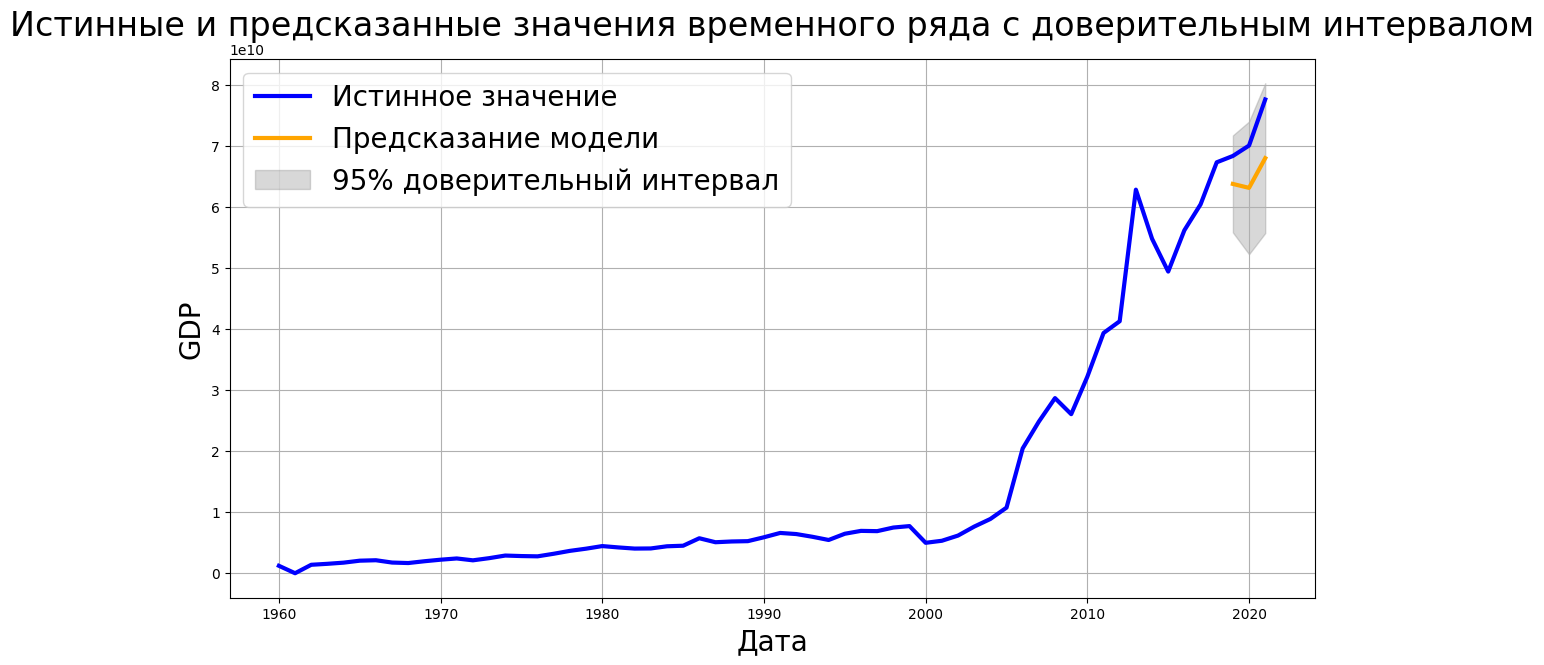

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Создадим DataFrame для предсказаний
pred_df = pd.DataFrame(index=data.index)

# Добавляем предсказания модели
pred_df["model_preds"] = best_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)

# Добавляем истинные значения GDP
pred_df["gdp"] = data["gdp"]

# Получаем прогноз и доверительные интервалы
forecast = best_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Уровень доверия 95%

# Записываем нижние и верхние границы доверительного интервала в DataFrame
pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower gdp"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper gdp"]

# Построение графиков
plt.figure(figsize=(14, 7))

# Истинные значения
plt.plot(pred_df["gdp"], label="Истинное значение", color="blue")

# Предсказанные значения
plt.plot(pred_df["model_preds"], label="Предсказание модели", color="orange")

# Доверительный интервал
plt.fill_between(
    pred_df.index,
    pred_df["model_preds_lower"],
    pred_df["model_preds_upper"],
    color="gray",
    alpha=0.3,
    label="95% доверительный интервал"
)

# Оформление
plt.title("Истинные и предсказанные значения временного ряда с доверительным интервалом")
plt.xlabel("Дата")
plt.ylabel("GDP")
plt.legend()
plt.grid(True)
plt.show()

Выводы: модель хорошо предсказывает следующие 3 года, реальные данные входят в доверительный интервал предсказания.

---
#  Интерполяция и сэмплирование.
---

Цель этого раздела в проверке: можно ли улучшить предсказание повысив частотность данных с помощью [интерполяции](https://ru.wikipedia.org/wiki/Интерполяция).

In [77]:
data

,gdp
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


## Проверка на пропущенные значения

In [78]:
# Проверка на наличие пропущенных дней
df_daily = data.asfreq('AS')

# Вывести пропущенные даты
missing_dates_daily = df_daily[df_daily.isnull().any(axis=1)]

print("Пропущенные даты (дни):")
print(missing_dates_daily)

Пропущенные даты (дни):
Empty DataFrame
Columns: [gdp]
Index: []


In [79]:
# Проверить количество пропущенных значений в каждом столбце
missing_values = data.isna().sum()
print("Пропущенные значения:")
print(missing_values)

Пропущенные значения:
gdp    0
dtype: int64


In [80]:
import numpy as np

# Заменить нули на NaN в столбце 'GDP (current US$)'
data['gdp'] = data['gdp'].apply(lambda x: np.nan if x == 0 else x)

In [81]:
# Интерполяция пропусков в данных
interpoly_data = data['gdp'].interpolate(method='linear')

In [82]:
def check_stationar(data):
    result = adfuller(data)
    print("adf: ", result[0])
    print("p-value: ", result[1])
    print("Critical values: ", result[4])
    if result[0] > result[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")

check_stationar(interpoly_data.diff().diff().diff().dropna())

adf:  -5.456208629828435
p-value:  2.578324497204482e-06
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд стационарен


## Автоподбор параметров для ARIMA

In [83]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Найдем оптимальные параметры с помощью pmdarima
auto_model = auto_arima(interpoly_data, seasonal=False, suppress_warnings=True)
p, d, q = auto_model.order

# Определение параметров ARIMA
# Обычно это делается через перебор параметров или использование таких методов, как AIC/BIC
model = ARIMA(interpoly_data, order=(p, d, q)) 
ARIMA_model_fit = model.fit()

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    gdp   No. Observations:                   62
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1403.760
Date:                Sun, 01 Sep 2024   AIC                           2817.521
Time:                        16:24:51   BIC                           2827.993
Sample:                    01-01-1960   HQIC                          2821.617
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0468      0.075    -13.905      0.000      -1.194      -0.899
ar.L2         -0.3350      0.139     -2.414      0.016      -0.607      -0.063
ma.L1          0.1108      0.100      1.103      0.2

In [84]:
# AIC до интерполяции
original_model = ARIMA(data['gdp'], order=(p, d, q))
original_model_fit = original_model.fit()
aic_before = original_model_fit.aic

# AIC после интерполяции
aic_after = model_fit.aic

print(f"AIC до интерполяции: {aic_before}")
print(f"AIC после интерполяции: {aic_after}")

AIC до интерполяции: 2819.3564415890946
AIC после интерполяции: 2589.1506591311304


# Выводы: Интерполяция уменьшила AIC на 200, что является улучшением модели ARIMA.

---
#  Модели прогнозирования гетероскедастичности. Валидация временных рядов.
---

# Волатильность

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [85]:
data["gdp_vol"] = data.gdp.pct_change(1).mul(100).abs()
data["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     0.000000
1962-01-01    13.578826
1963-01-01    11.448835
1964-01-01    12.363636
Name: gdp_vol, dtype: float64

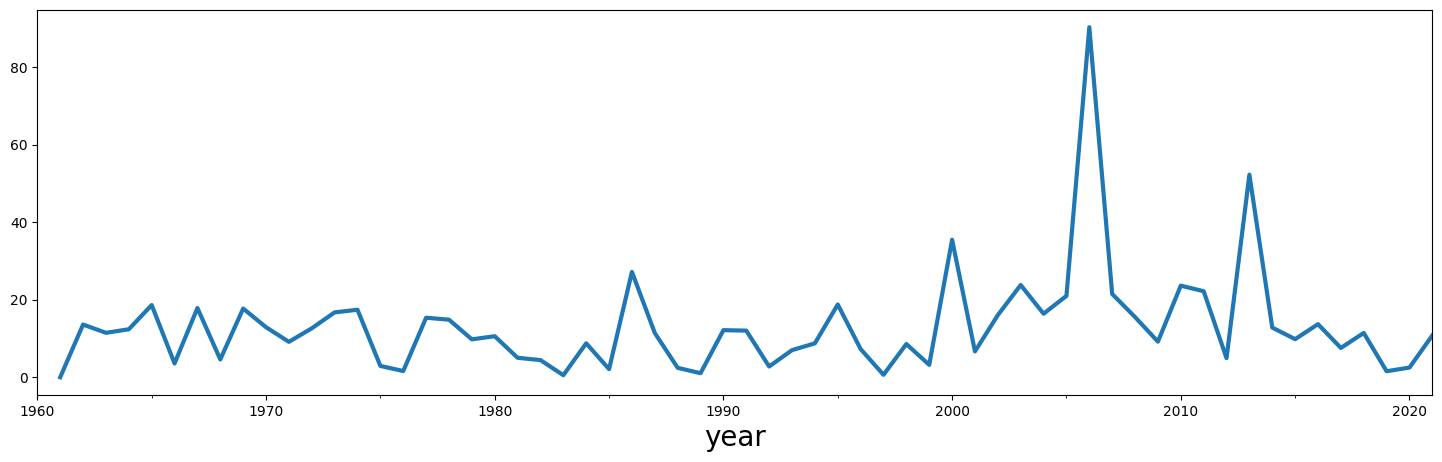

In [86]:
data["gdp_vol"].plot()
plt.show()

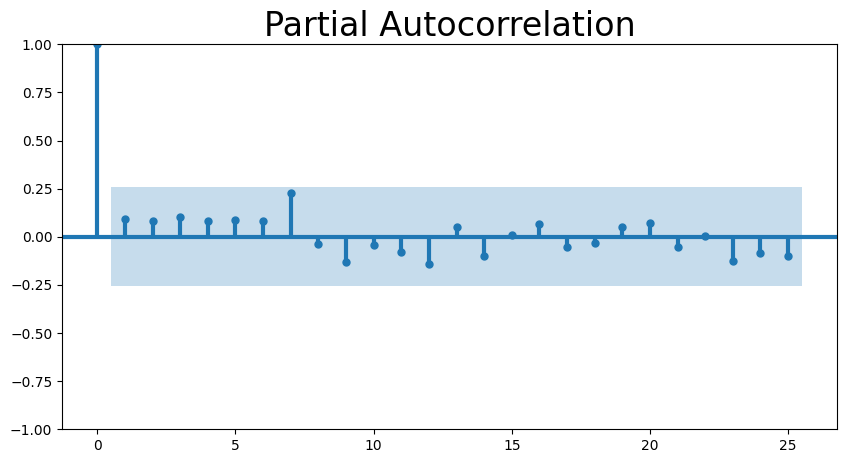

In [87]:
from matplotlib import pyplot as plt

train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.gdp_vol[1:], lags=25, method="ywm")
plt.show()

In [88]:
adfuller(train_df.gdp_vol[1:])

(-6.816105099260228,
 2.0572875762632108e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [89]:
garch_df = pd.DataFrame(data["gdp_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

In [90]:
from arch import arch_model

model = arch_model(garch_df["gdp_vol"].dropna(), p=7, q=7)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     91,   Neg. LLF: 238.85932252411234
Iteration:     10,   Func. Count:    179,   Neg. LLF: 215.54503184225177
Iteration:     15,   Func. Count:    264,   Neg. LLF: 215.30040785396184
Iteration:     20,   Func. Count:    349,   Neg. LLF: 214.92020066801985
Iteration:     25,   Func. Count:    434,   Neg. LLF: 214.73614860315595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214.7350352111361
            Iterations: 30
            Function evaluations: 507
            Gradient evaluations: 29


In [91]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -214.735
Distribution:                  Normal   AIC:                           461.470
Method:            Maximum Likelihood   BIC:                           494.437
                                        No. Observations:                   58
Date:                Sun, Sep 01 2024   Df Residuals:                       57
Time:                        16:24:52   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.7865      1.447      8.143  3.867e-16 [  8.949, 14.624]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         45.3475     36.934      1.228      0.220    [-27.042,1.177e+02]
alpha[1]   3.0834e-13  6.081e-02  5.070e-12      1.000      [ -0.119,  0.119]
alpha[2]   1.1349e-12  2.157e-02  5.261e-11      1.000 [-4.228e-02,4.228e-02]
alpha[3]   2.3705e-08  5.798e-02  4.088e-07      1.000      [ -0.114,  0.114]
alpha[4]   3.4226e-03  1.175e-02      0.291      0.771 [-1.961e-02,2.646e-02]
alpha[5]   1.0555e-08  1.088e-02  9.701e-07      1.000 [-2.133e-02,2.133e-02]
alpha[6]       0.7280      0.787      0.925      0.355      [ -0.814,  2.270]
alpha[7]       0.1022      0.479      0.213      0.831      [ -0.837,  1.041]
beta[1]    9.4659e-14      0.382  2.476e-13      1.000      [ -0.749,  0.749]
beta[2]    7.7394e-13  4.690e-02  1.650e-11      1.000 [-9.192e-02,9.192e-02]
beta[3]    8.7275e-13  2.535e-02  3.442e-11      1.000 [-4.969e-02,4.969e-02]
beta[4]    3.2388e-13  7.371e-02  4.394e-12      1.000      [ -0.144,  0.144]
beta[5]    1.9898e-13  5.185e-02  3.838e-12      1.000      [ -0.102,  0.102]
beta[6]    4.8081e-13  2.751e-02  1.748e-11      1.000 [-5.391e-02,5.391e-02]
beta[7]    7.7476e-14      0.899  8.615e-14      1.000      [ -1.763,  1.763]
=============================================================================

Covariance estimator: robust
"""

In [92]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

## Сравнение предсказаний и реальных значений волатильности

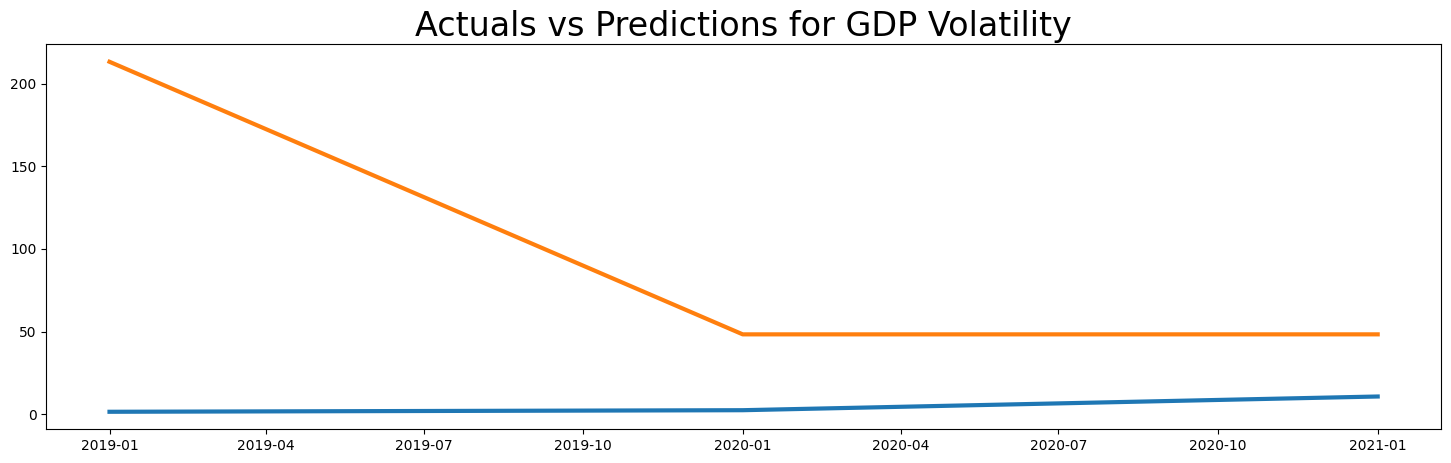

In [93]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["gdp_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP Volatility", size=24)

plt.show()

In [94]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
)

16096.400115159666

### Также посмторим как справится Линейная регрессия

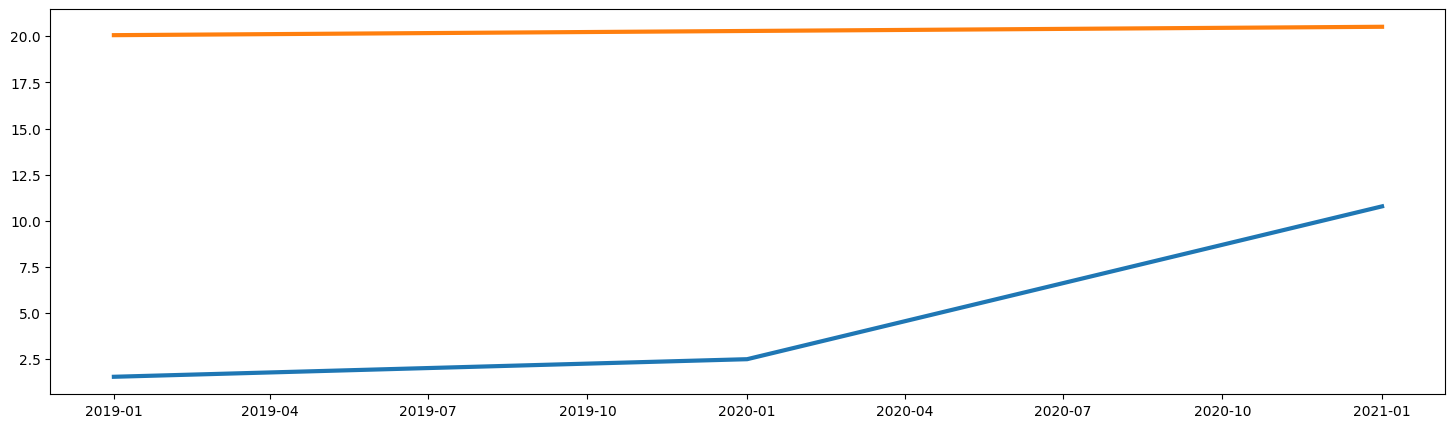

In [95]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

Выводы: модель GARCH лучше уловила закономерности в данных, хоть и далеко не идеально, но в сравнении с LinearRegression справилась она просто отлично.

# Валидация

В целом она нужна для отслеживания улучшения или ухудшения модели, и для объективного оценивания с другими различными моделями.
Используйте её когда создаёте больше 3 моделей для прогноза.

In [96]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.rename(columns={"GDP (current US$)":"gdp"}, inplace=True)

In [97]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3, max_train_size=None, test_size=None, gap=0)

In [98]:
train_test_groups = tscv.split(data.gdp)
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 17 TEST size: 15
TRAIN size: 32 TEST size: 15
TRAIN size: 47 TEST size: 15


Выводы валидации: Можно в цикле обучать и сравнивать ошибки, чтобы повышать качество модели.

In [99]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

# Модель
model = LinearRegression()

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, max_train_size=None, test_size=None, gap=0)

mse_scores = []

for train_index, test_index in tscv.split(data):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

print("Средняя ошибка MSE по всем окнам:", np.mean(mse_scores))

Средняя ошибка MSE по всем окнам: 251.36459946844437


Выводы валидации: валидация данных временных рядов является критическим этапом в построении надежной и устойчивой модели, показывая как хорошо она улавливает взаимосвязь данных.